In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from IPython.display import HTML

## Projeto 2 de Modelagem Matemática: Pêndulo com oscilações de grande amplitude

#### Aluno: Leonardo Bohac

#### Entregue no dia 28/04/2019

Neste Projeto será feita a análise do movimento de um pêndulo, considerando ângulos grandes de oscilação e também a influência exercida pela resistência do ar para se ter uma descrição mais precisa de sua realidade.

Os dados experimentais foram obtidos através do processamento de imagens (quadros) oriundas de um vídeo que filma um pêndulo se movimentando.

In [2]:
# Vídeo

HTML('<img src="./Detection/OriginalVideo.gif">')

Achei que seria interessante fazer a detecção de movimento por conta própria, portanto a fiz no arquivo *Detection.ipynb*, localizado na pasta */Detection/* deste diretório. Segue abaixo o resultado da detecção:

In [3]:
# Detecção

HTML('<img src="./Detection/DetectionVideo.gif">')

A detecção acima localiza o centro de massa do pêndulo (representado pela bolinha vermelha) ao longo do tempo. Vamos ver como se comportam suas componentes $x$ e $y$:

In [4]:
DotMass_XY = np.load('./Detection/DotMass_XY.npy')[200:-200]  # estou considerando a porção do vídeo onde o centro de massa é estável (eliminando o início e o final do vídeo)

DotMass_X  = DotMass_XY.T[0]
DotMass_Y  = DotMass_XY.T[1]

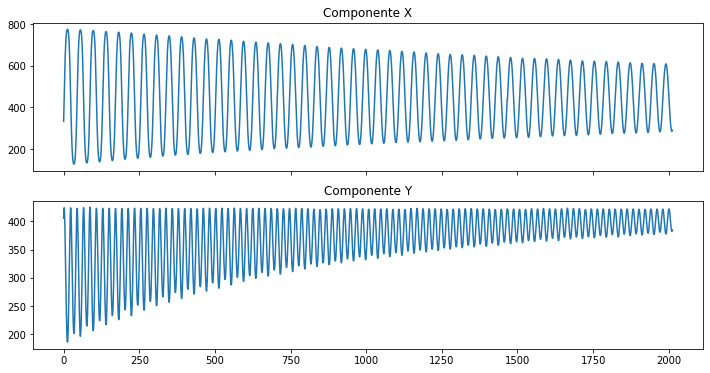

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.set_title('Componente X')
ax2.set_title('Componente Y')

ax1.plot(DotMass_X);
ax2.plot(DotMass_Y);

O eixo horizontal dos gráficos acima representa o quadro (*frame*) do vídeo e o eixo vertical representa a posição, em pixels, de cada componente.

Para facilitar as contas e tornar o problema mais "físico", vamos deslocar a origem do sistema de pixels para o ponto fixo de oscilação, e também fazer as conversões de unidade: Pixel $\leftrightarrow$ Metro; Frame $\leftrightarrow$ Segundo.

A maneira mais simples de encontrar o ponto fixo de oscilação foi pegar o primeiro quadro do vídeo, desenhar uma bolinha branca em cima do ponto fixo (imagem salva como *FixedPoint.png*), e então fazer o processamento de imagem para encontrar o centro dessa bolinha branca:

In [6]:
# Encontrando o ponto fixo de oscilação

FixedPointImage = plt.imread('FixedPoint.png', 0).mean(axis=2)   # lendo a imagem em grayscale

FixedPosition = np.mean(np.argwhere(FixedPointImage == 255), axis=0).astype(np.int)  #  encontrando o centro da bolinha branca

FixedPosition = FixedPosition[::-1]

In [7]:
FixedPosition

array([441,  73])

O ponto fixo de oscilação possui coordenadas $x_{F} = 441$ e $y_{F} = 73$ em pixels. Podemos então deslocar a origem do sistema de coordenadas para o ponto fixo:

In [8]:
DotMass_X -= FixedPosition[0]
DotMass_Y -= FixedPosition[1]

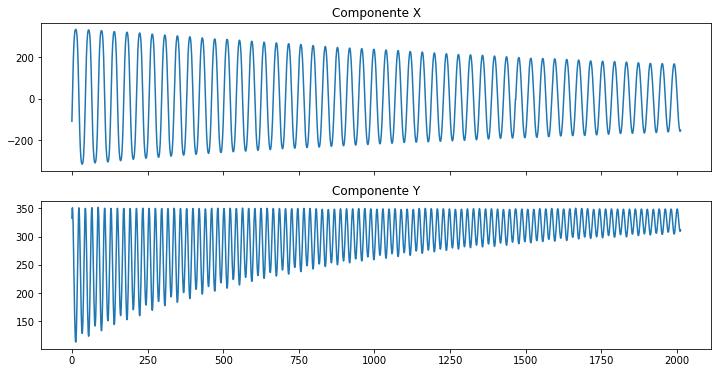

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.set_title('Componente X')
ax2.set_title('Componente Y')

ax1.plot(DotMass_X);
ax2.plot(DotMass_Y);

Para fazer a conversão Pixel $\leftrightarrow$ Metro, podemos encontrar a coordenada $y$, em pixel, do pêndulo quando ele está vertical e dividir pelo comprimento do pêndulo ($0.4m$).

O pêndulo vai estar na posição vertical quando sua coordenada $y$ for máxima, portanto:

In [10]:
PxM_Rate = DotMass_Y.max() / 0.4

PxM_Rate

879.8351158645276

Assim podemos converter as posições das componentes para centímetros:

In [11]:
DotMass_X /= PxM_Rate
DotMass_Y /= PxM_Rate

E transformar quadros em segundos, através do *fps = 30*:

In [12]:
fps = 30

Time = np.arange(DotMass_X.size) / fps    # poderia ser DotMass_Y também

Assim nossos gráficos ficam:

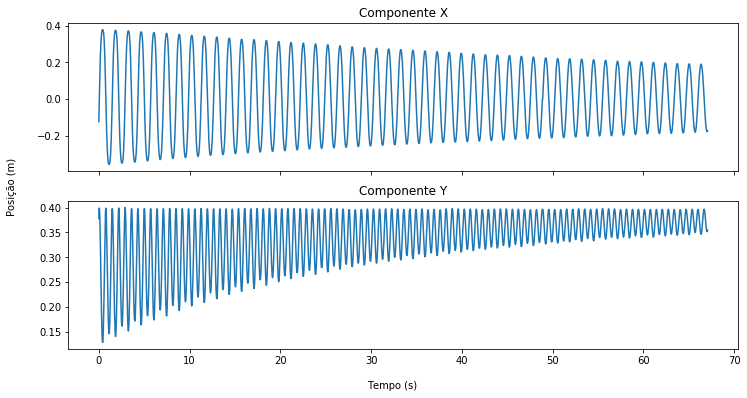

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

fig.text(0.5, 0.04, 'Tempo (s)', ha='center', va='center')
fig.text(0.06, 0.5, 'Posição (m)', ha='center', va='center', rotation='vertical')

ax1.set_title('Componente X')
ax2.set_title('Componente Y')

ax1.plot(Time, DotMass_X);
ax2.plot(Time, DotMass_Y);

Por enquanto ainda não fizemos nenhuma "modelagem" própriamente dita, mas já estamos com o caminho pavimentado.

A primeira impressão que temos quando olhamos estes gráficos é que a Componente X parece estar bem comportada e de acordo com nossa intuição, enquanto que a Componente Y está certamente munida de erros relevantes (afinal de contas as diferenças nos picos de mínimo indicam uma violação na Lei da Conservação de Energia, pois o pêndulo não pode ir mais alto do que foi na oscilação anterior).

Infelizmente, ambas estão 'igualmente erradas'. A explicação intuitiva do porquê disso, é que os defeitos de medida provavelmente aconteceram pois existe um desalinhamento do plano de oscilação com o plano de filmagem, e esse desalinhamento modifica tanto a Coordenada X quanto à Y.

Essa explicação intuitiva não é muito 'rigorosa', e é provável que ela não nos convença de que a Coordenada X está de fato errada relevantement. No entanto podemos encontrar um motivo analítico que demonstra a incoerência nesta Coordenada.

Vamos supor que ela, a Coordenada X, está bonitinha, bem comportada, somente com alguns erros que não podem não existir. Como temos um pêndulo de comprimento (muito precisamente) constante, podemos encontrar as Coordenadas Y, sem sequer ter precisado medí-las, diretamente a partir das Coordenadas X, através da relação:

$X^{2} + Y^{2} = L^{2}$, onde $L=0.4m$ é o comprimento do pêndulo.

Veja o que acontece:

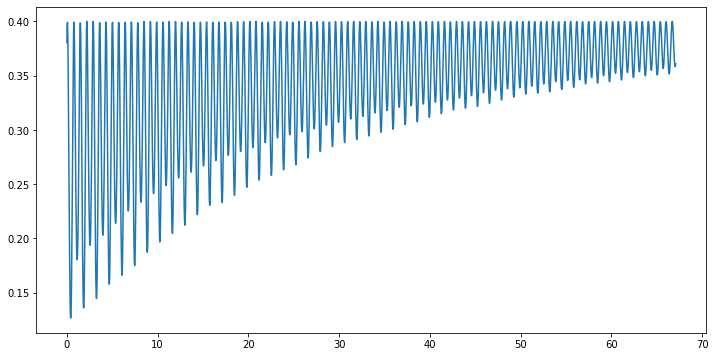

In [14]:
plt.figure(figsize=(12,6))

Ideal_Y = np.sqrt(0.4**2 - DotMass_X**2)

plt.plot(Time, Ideal_Y)

Continua com as diferenças nos picos! Isso nos mostra que o erro na Coordenada X também está violando a Lei de Conservação de Energia.

Seria imprudente continuar com nossa modelagem, ou seja, descrever o ângulo $\theta$ do pêndulo, sem antes nos livrarmos dos problemas que surgiram na medição.

Uma possível tentativa de corrigir os erros é buscar uma transformação na geometria espacial considerando que a raiz dos problemas é um desalinhamento de planos, mas, além de não termos certeza de que essa é, de fato, a raiz dos problemas, precisaríamos de informações impossíveis de se obter, como por exemplo a distância da câmera ao pêndulo, a altura da câmera, a altura do pêndulo...e mesmo que soubéssemos essas informações, a geometria continuaria sendo demasiadamente engenhosa.

Permitamo-nos então abusar um pouco da nossa intuição sobre como deve ser o comportamento qualitativo do movimento do pêndulo.

É irrevogável o fato de que a amplitude de oscilação decresce ao passar do tempo. Tendo isso em mente, e olhando para o gráfico da Coordenada X, parece correto modelá-la como uma oscilação harmônica amortecida (com um amortecimento bem aproximado por alguma exponencial de decaimento).

Portanto, busquemos uma equação para X da forma $X = X_{0} \cdot e^{\alpha t} \cdot \cos{(2\pi\beta t)} $

Primeiro podemos encontrar o parâmetro $\beta$ como sendo a frequência observada na oscilação da Coordenada X:

In [15]:
# Calculando o período como sendo o dobro do tempo médio entre duas passagens consecutivas por X = 0

# Considerarei X = 0 como os pontos em que a coordenada X muda de sinal

Period = 2 * np.mean(np.gradient(Time[np.argwhere(DotMass_X * np.roll(DotMass_X, -1) < 0).flatten()]))

Period

1.3466666666666671

In [16]:
beta = 1 / Period

beta

0.7425742574257423

Para encontrar o parâmetro $\alpha$, podemos fazer uma regressão na amplitude de oscilação da Coordenada X, que vou considerar como a média da amplitude num ponto máximo como a amplitude no ponto mínimo que se sucede:

In [17]:
X_Maxs = DotMass_X[(DotMass_X > np.roll(DotMass_X, 1)) & (DotMass_X > np.roll(DotMass_X, -1))] # pontos com valor maior que o ponto anterior e posterior

X_Mins = DotMass_X[(DotMass_X < np.roll(DotMass_X, 1)) & (DotMass_X < np.roll(DotMass_X, -1))] # pontos com valor menor que o ponto anterior e posterior

Amplitudes = (X_Maxs + abs(X_Mins)) / 2

time_of_first_max = Time[np.argwhere(DotMass_X == X_Maxs[0])[0]][0]  # instante em que ocorre o primeiro máximo
time_of_last_max = Time[np.argwhere(DotMass_X == X_Maxs[-1])[0]][0]  # instante em que ocorre o último máximo

Amplitudes_Time = np.linspace(time_of_first_max, time_of_last_max, Amplitudes.size)

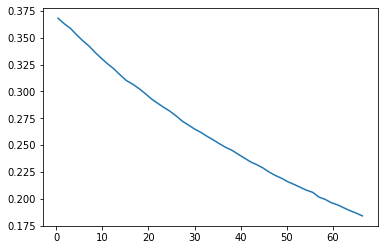

In [18]:
plt.plot(Amplitudes_Time, Amplitudes)

Para fitar a exponencial de decaimento, vamos fazer uma regressão linear nos pontos transformados $\big(t, \ln{(\text{Amplitude})}\big)$:

In [19]:
T = np.vstack([Amplitudes_Time, np.ones(len(Amplitudes_Time))]).T

alpha, c = np.linalg.lstsq(T, np.log(Amplitudes), rcond=None)[0]

X_0 = np.exp(c)

In [20]:
alpha, X_0

(-0.010471800073657679, 0.3660457747106723)

Agora que temos $X_{0}$, $\alpha$ e $\beta$, podemos comparar a Coordenada X observada com a que corrigimos:

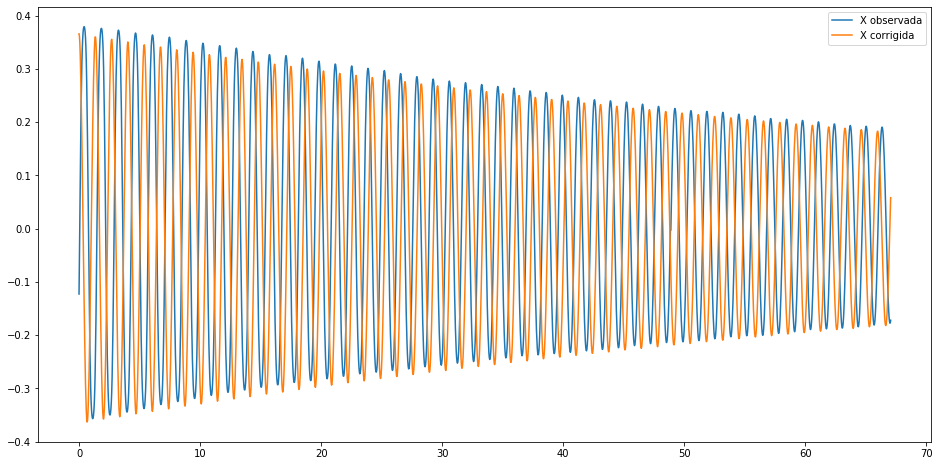

In [21]:
Fixed_DotMass_X = X_0 * np.exp(alpha * Time) * np.cos(2*np.pi*beta*Time)

plt.figure(figsize=(16,8))

plt.plot(Time, DotMass_X, label='X observada')
plt.plot(Time, Fixed_DotMass_X, label='X corrigida')
plt.legend()

Nada mal! Apesar dos gráficos não estarem 'iguaizinhos', o que é na verdade bom pois a Coordenada X observada possuía erros de medição, o comportamento qualitativo de ambos é muito parecido.

Agora com a nossa Coordenada X corrigida, vamos prosseguir com a modelagem diretamente pelas relações:

In [22]:
Fixed_DotMass_Y = np.sqrt(0.4**2 - Fixed_DotMass_X**2)

Theta = np.arctan(Fixed_DotMass_X / Fixed_DotMass_Y)

Visualizando:

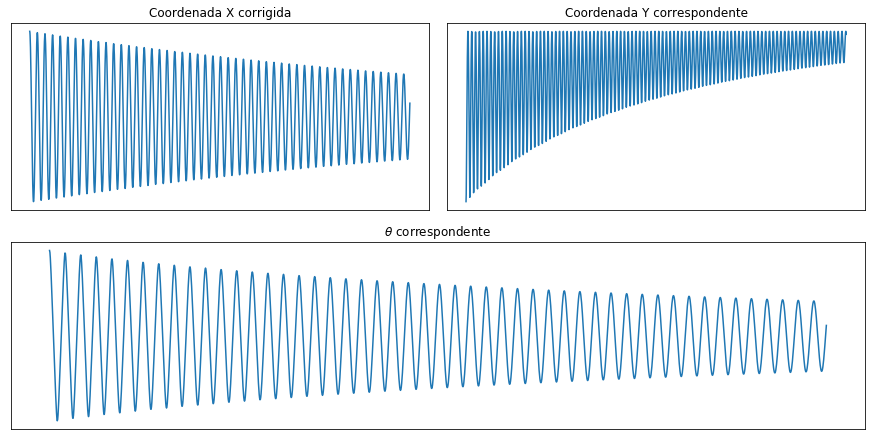

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(12,6))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Coordenada X corrigida')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Coordenada Y correspondente')

ax3 = fig.add_subplot(gs[1, :])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title(r'$\theta$'+' correspondente')


ax1.plot(Fixed_DotMass_X);
ax2.plot(Fixed_DotMass_Y);
ax3.plot(Theta);

Parece muito bom, e por ora já temos uma fórmula fechada para $\theta$ ! Que é simplesmente:

$\theta = \arctan{\Bigg(\cfrac{X}{\sqrt{0.4^2 - X^2}}\Bigg)}\;\;$, com $\;X = X_{0} \cdot e^{\alpha t} \cdot \cos{(2\pi\beta t)}$

Mas como queremos entender melhor as leis físicas por detrás do movimento do pêndulo, seria interessante ver como se relacionam $\theta$ e suas derivadas. Façamos um gráfico, mas antes precisamos encontrar as derivadas...

In [24]:
def Derivative(V, h=1/fps):
    
    return np.gradient(V) / (h)

In [25]:
DTheta = Derivative(Theta)

D2Theta = Derivative(DTheta)

Graficamente:

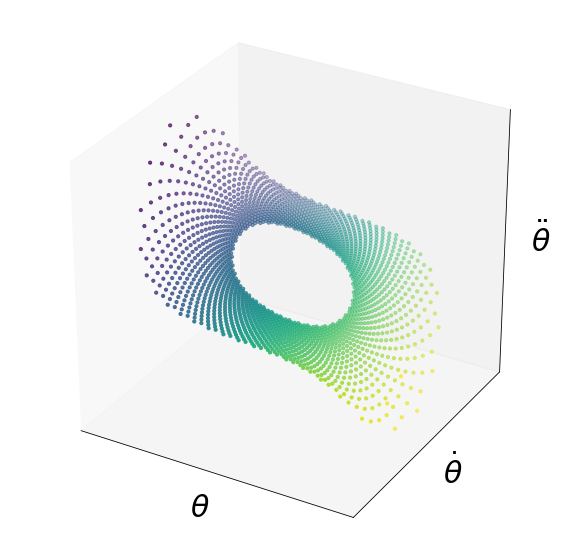

In [26]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel(r'$\theta$', fontsize=30, rotation = 0)
ax.set_ylabel(r'$\dot\theta$', fontsize=30, rotation = 0)
ax.set_zlabel(r'$\ddot\theta$', fontsize=30, rotation = 0)

ax.scatter3D(Theta[:-2], DTheta[:-2], D2Theta[:-2], c=Theta[:-2], s=10);

Como conclusão deste projeto, gostaria de elucidar que o processo de modelagem do pêndulo foi bastante produtivo e desafiador, e também deixar como objetivo futuro a remodelagem do mesmo fenômeno através de vídeos produzidos com alto teor laboratorial (para não haver margem de dúvida quanto à fidelidade dos dados observados) incluindo uma gama mais ampla de comprimentos possíveis para o pêndulo.